# Les bennes à verre dans la CALL

La source des données provient de : https://opendata.agglo-lenslievin.fr/ <br>
Il y a eu un traitement des données, plus de detail sur le notebook [Analyse_dataset](Analyse_dataset.ipynb) <br>


In [53]:
#import des bibliothèques
import locale


import pandas as pd
import geopandas as gpd

from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns


In [54]:
def scatter_text(ax,x, y, text_column, data):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(data=data,x=x,y=y, size = 8, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')   

In [55]:
#definit la norme fr pour les chiffre par exempple
locale.setlocale(locale.LC_NUMERIC, 'fr_FR.UTF-8')

# import des fichiers
benne_verre = pd.read_csv('donnee/benne_verre.csv')

#import carte
font_carte = gpd.read_file('donnee/font_carte.gdp')
carte_benne = gpd.read_file('donnee/carteverre.gpd/')

In [56]:
sns.set_theme(style='dark')
palette=sns.color_palette()

## Généralité :

In [57]:
#affichage moyenne generale
total_nb_benne = int(benne_verre['nb_benne'].sum())
total_volume = int(benne_verre['volume_borne__m3_'].sum())
total_population = int(benne_verre['Population_municipale_2020'].sum())
nb_commune = benne_verre['commune'].count()
print("La population de la CALL en 2020 est de", '{:n}' .format(total_population),"habitants")
print("Il y a ",total_nb_benne,"bennes de verre sur le territoire pour un volume total de",total_volume,"m³")
print("Il y a donc",int(total_population/total_nb_benne),"habitants pour chaque benne en moyenne")
#cliiikk
total_cliink = benne_verre['cliiink'].sum()
print("Il y a ",total_cliink/total_nb_benne*100,"% de benne qui ont l'option CLIIINK")

La population de la CALL en 2020 est de 242 238 habitants
Il y a  500 bennes de verre sur le territoire pour un volume total de 1521 m³
Il y a donc 484 habitants pour chaque benne en moyenne
Il y a  39.0 % de benne qui ont l'option CLIIINK


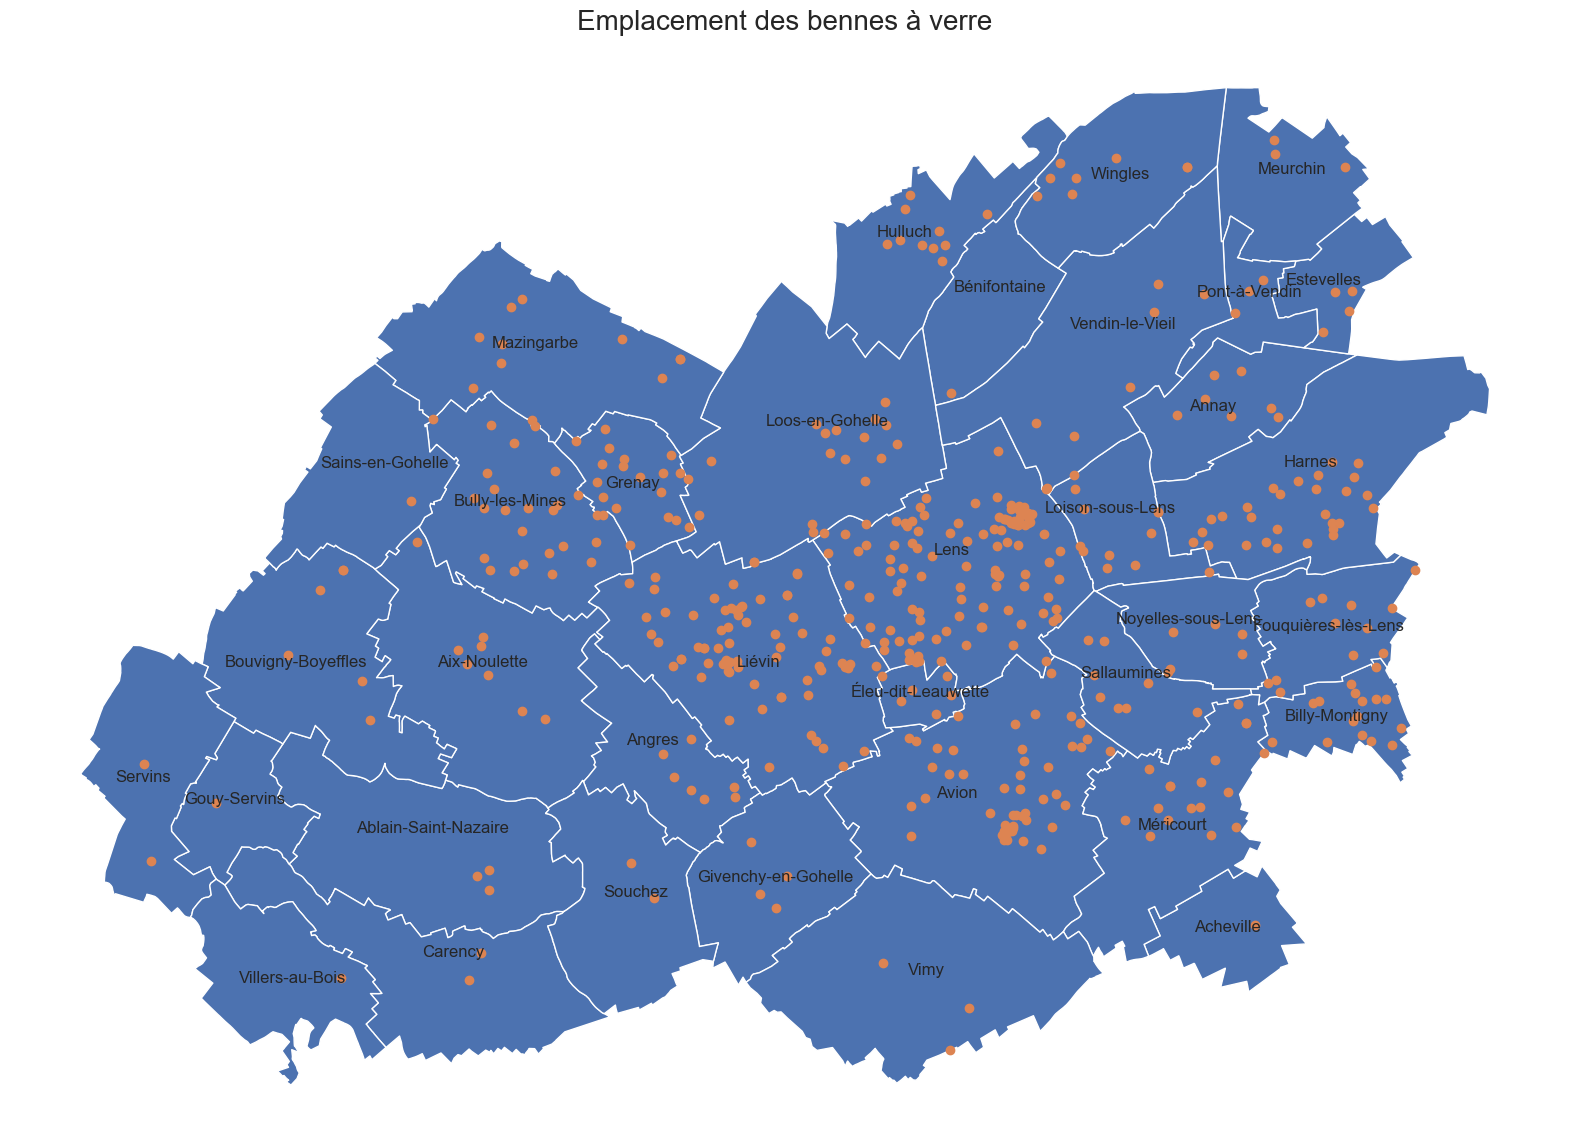

In [58]:
#carte

#creation de la figure matplotlib
fig,ax = plt.subplots(figsize=(20,20))
#affichage font de carte
font_carte.plot(ax=ax)

#annoté la carte
font_carte['coords'] = font_carte['geometry'].apply(lambda x: x.representative_point().coords[:])
font_carte['coords'] = [coords[0] for coords in font_carte['coords']]

for idx, row in font_carte.iterrows():
    plt.annotate(text=row['Libelle'], xy=row['coords'], horizontalalignment='center')
    
#creation des points oú sont les bennes
carte_benne.plot(ax=ax,color=palette[1])
ax.set_title('Emplacement des bennes à verre',fontsize=20)
ax.axis('off')
plt.show()


Sans grande surprise, les bennes se situent au niveau des grandes villes. 

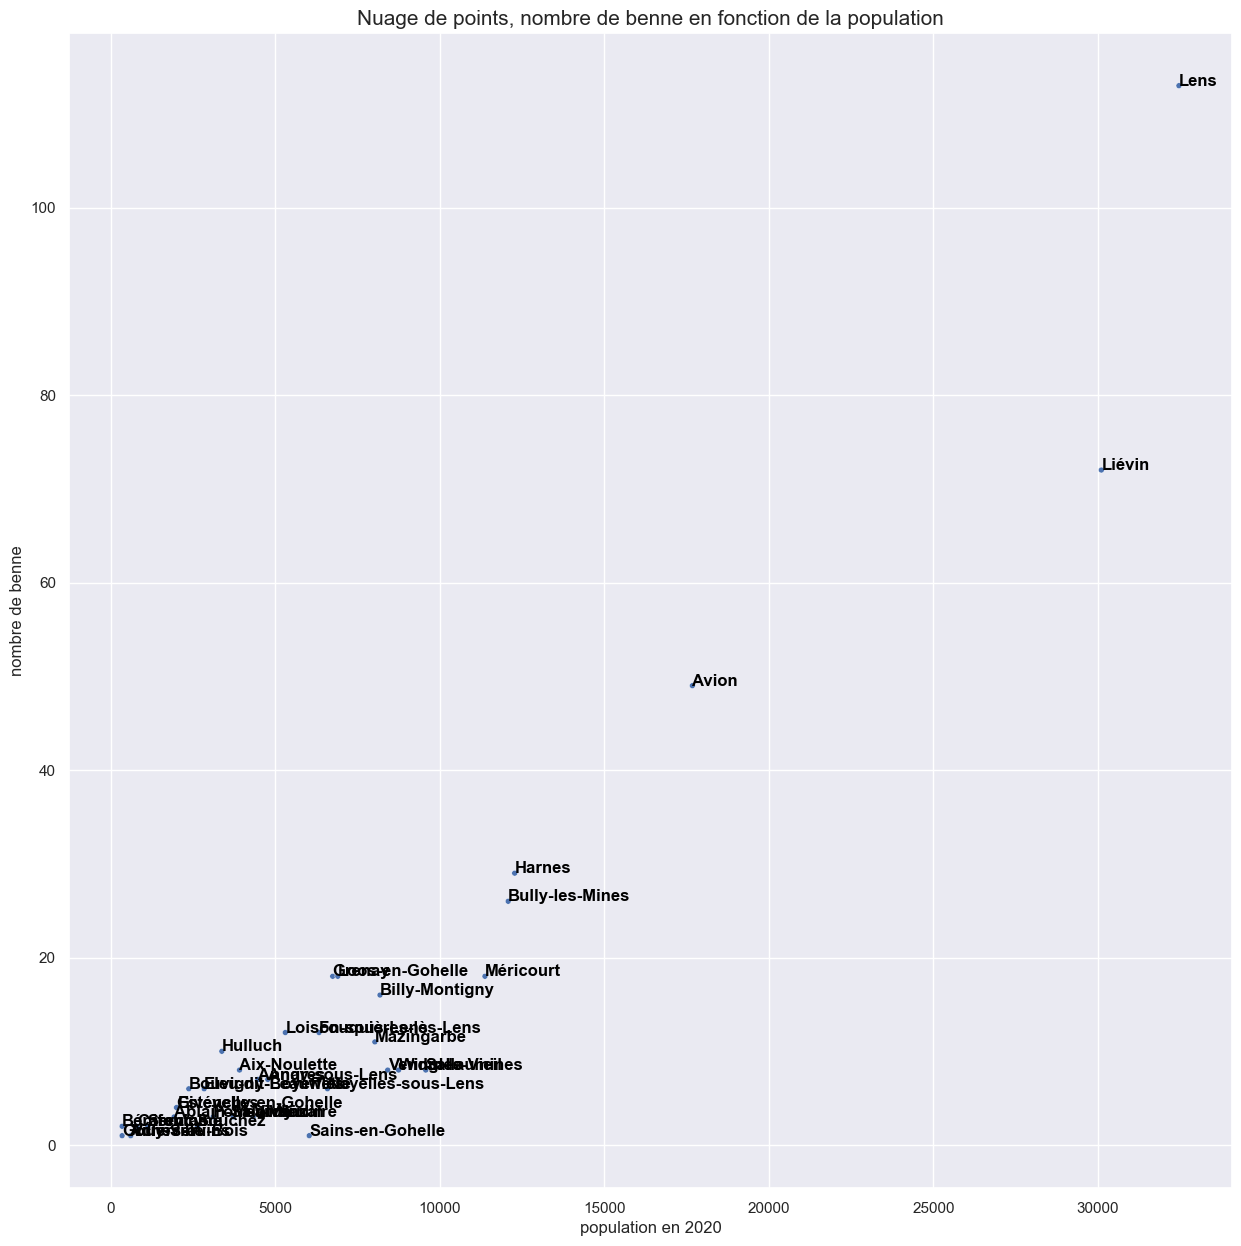

In [59]:
#affichage graphe
sns.set_theme(style='darkgrid')
#nuage de point population/nbbenne
fig, ax = plt.subplots(figsize=(15,15))
scatter_text(ax=ax,data = benne_verre , x='Population_municipale_2020',y='nb_benne',text_column='commune')

ax.set_title('Nuage de points, nombre de benne en fonction de la population',fontsize=15)
ax.set_xlabel('population en 2020')
ax.set_ylabel('nombre de benne')
plt.show()


Au plus la ville est peuplée, au plus il y a de benne.<br>
Par contre Sains-en-gohelle devrait avoir logiquement avoir plus de benne à verre.<br>

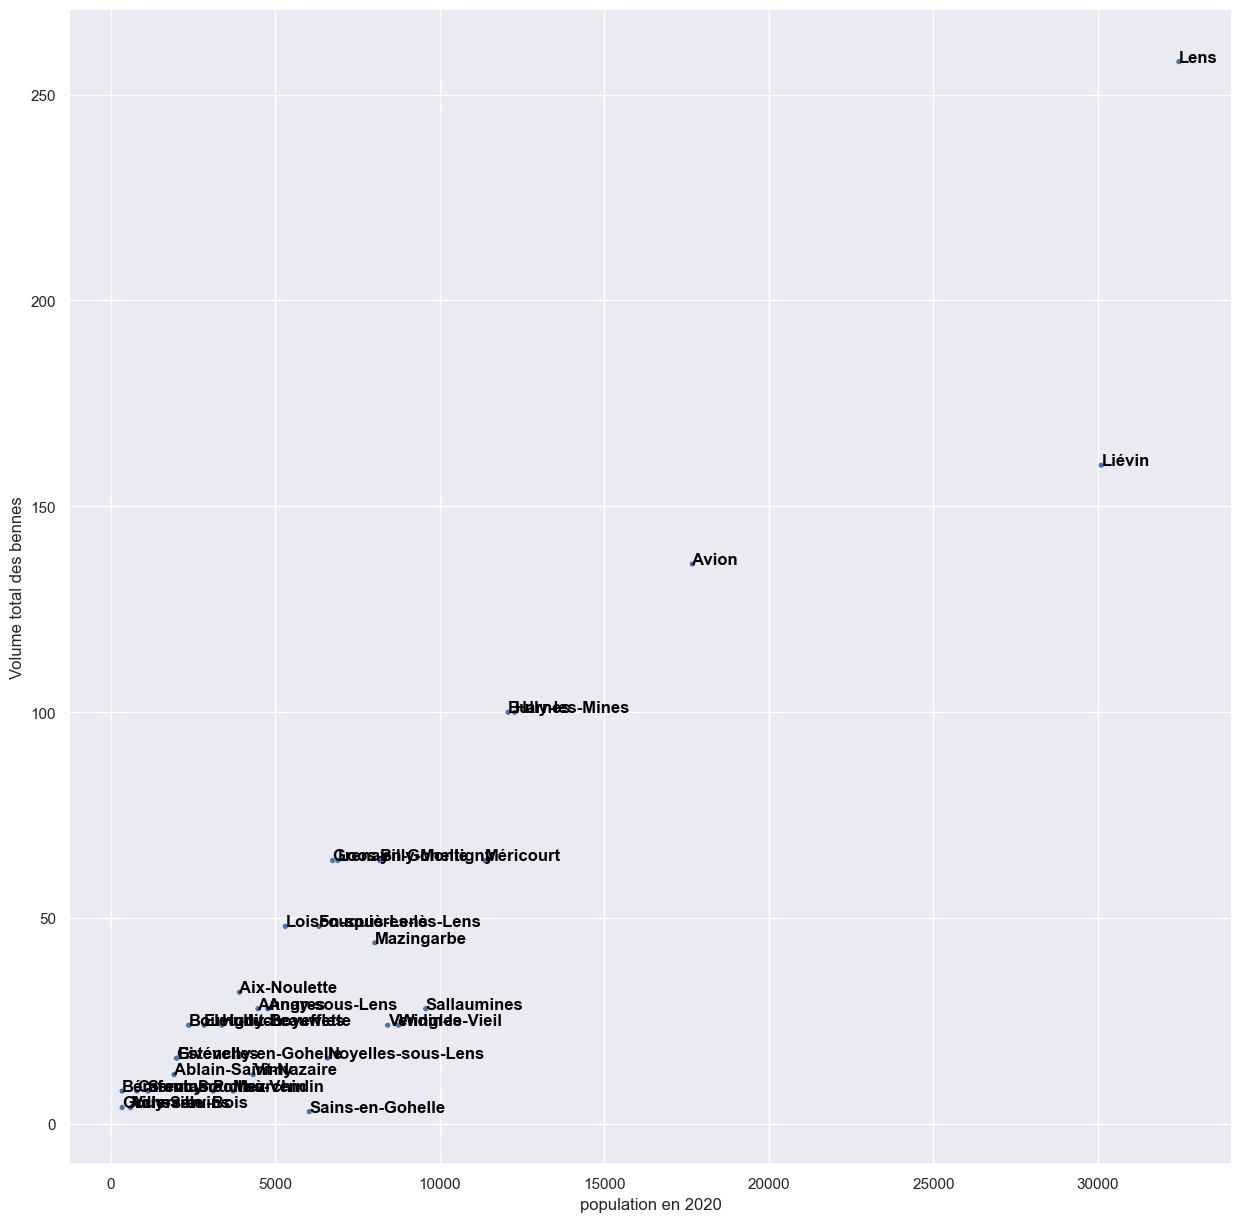

In [60]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_text(ax=ax,data = benne_verre , x='Population_municipale_2020',y='volume_borne__m3_',text_column='commune')
    
ax.set_xlabel('population en 2020')
ax.set_ylabel('Volume total des bennes')
plt.show()


Si on regarde le volume des bennes, il y a peu de changement. Le cas de sains-en-gohelle est toujours étrange

In [61]:
benne_verre["moyenne d'habitant par benne"] = benne_verre['Population_municipale_2020']/benne_verre['nb_benne']

## Cas de Bouvigny_boyeffles

In [62]:
display(benne_verre[benne_verre['commune'] == 'Bouvigny-Boyeffles'])


,commune,volume_borne__m3_,trappe_gros_producteurs,cliiink,consignes_de_tri_à_jour,nb_benne,Population_municipale_2020,moyenne d'habitant par benne
7,Bouvigny-Boyeffles,24.0,0,2,0,6,2376,396.0


Avec une moyenne de 396 habitants par benne, Bouvigny-Boyeffles possède un nombre correct de benne à verre.

## Cas de Sains-en-Gohelle

In [63]:
display(benne_verre[benne_verre['commune'] == 'Sains-en-Gohelle'])

,commune,volume_borne__m3_,trappe_gros_producteurs,cliiink,consignes_de_tri_à_jour,nb_benne,Population_municipale_2020,moyenne d'habitant par benne
28,Sains-en-Gohelle,3.0,1,0,1,1,6035,6035.0


Avec une seule benne pour toute sa population (6035 âmes), le cas de Sains-en-Gohelle est étrange. 